In [3]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import cloudpickle as pickle
import os
from tqdm.auto import tqdm
import pandas as pd
from causal_util.helpers import CPU_Unpickler
from encoder.digit_encoder import digit_to_np
import seaborn as sns
from matplotlib import pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

# Analyzing the fitted model
- The graph is sparse
- Reconstruction loss is low
- Features are a bit more correlated with the digits!

In [4]:
trial_name = 'main_fcn_cbb6f_00000_0_2021-02-26_18-48-12'
config_name = 'rl_const_sparsity_obs_space_env_ve5_with_rew_done'
ckpt = f'/home/sergei/ray_results/{config_name}/{trial_name}/checkpoint_25000/checkpoint'

In [ ]:
l = CPU_Unpickler(open(ckpt, 'rb')).load()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [4]:
ctx = l.collect_and_get_context()

In [5]:
l.config.get('losses')['fit']['fcn'](**ctx, loss_local_cache={})

{'loss': tensor(0.1306, grad_fn=<MeanBackward1>),
 'metrics': {'mean_feature': array([ -4.7786145,  -7.6787066, -19.23142  ,  30.27271  ,  -8.64064  ,
          16.713377 ], dtype=float32),
  'std_feature': array([ 6.3924875,  9.788592 , 13.876536 , 18.767221 ,  8.039848 ,
         43.65536  ], dtype=float32),
  'min_feature': -46.5193977355957,
  'max_feature': 155.84068298339844,
  'loss_fcons': 0.027260400354862213,
  'loss_add': 0.033007387071847916,
  'loss_rec': 0.13060793280601501,
  'loss_fcons_pre': 0.028631586581468582,
  'rec_fit_acc_loss_01_agg': 1.0000737309455872}}

In [6]:
def unperm(obs):
    unperm = np.argsort(l.env.env.perm)
    return obs.flatten()[unperm].reshape(obs.shape)

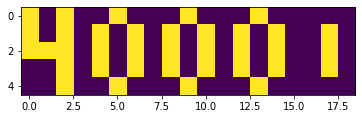

In [7]:
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_x'])[0].detach().cpu().numpy()))

In [8]:
fx = l.decoder(ctx['obs_x'])

In [9]:
fnext_model = l.model(l.rot_pre(fx), ctx['action_x'], all=True)
fnext = l.rot_post(fnext_model[:, :l.feature_shape[0]])

In [10]:
obs_rec = l.reconstructor(fnext)
obs_rec_denorm = l.normalizers['obs'].unnormalize(obs_rec.detach().numpy())

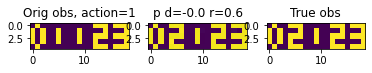

In [11]:
idx = np.random.choice(len(fx))
rew = round(l.normalizers['rew_y'].unnormalize(
    np.array([fnext_model[idx, l.feature_shape[0]:][0].item()]))[0], 2)
done = round(l.normalizers['done_y'].unnormalize(
    np.array([fnext_model[idx, l.feature_shape[0]:][1].item()]))[0], 2)
plt.subplot(1, 3, 1)
plt.title(f'Orig obs, action={np.argmax(ctx["action_x"][idx].numpy())}')
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_x'])[idx].detach().cpu().numpy()))
plt.subplot(1, 3, 2)
plt.title(f"p d={done} r={rew}")
plt.imshow(unperm(obs_rec_denorm[idx]))
plt.subplot(1, 3, 3)
plt.title("True obs")
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_y'])[idx].detach().cpu().numpy()))

In [12]:
rew_true = ctx['rew_y'].flatten().numpy()
rew_pred = fnext_model[:, l.feature_shape[0]:][:, 0].flatten().detach().numpy()

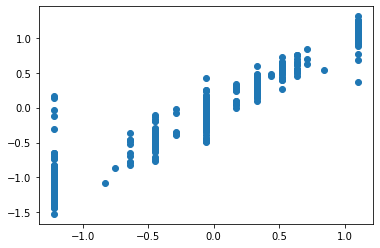

In [13]:
plt.scatter(rew_true, rew_pred)

In [14]:
done_true = ctx['done_y'].flatten().numpy()
done_pred = fnext_model[:, l.feature_shape[0]:][:, 1].flatten().detach().numpy()

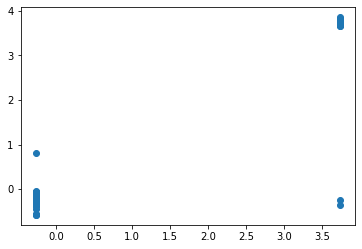

In [15]:
plt.scatter(done_true, done_pred)

In [16]:
obs_x_unnorm = l.normalizers['obs'].unnormalize(ctx['obs_x']).detach().cpu().numpy()

In [17]:
digits = [1. * digit_to_np(z) for z in range(22)]

In [18]:
obs = unperm(obs_x_unnorm[0])

In [39]:
def obs_to_digits(obs_unperm):
    offset = 0
    r = []
    while offset + 3 <= obs_unperm.shape[1]:
        r.append(obs_unperm[:, offset:offset+3])
        offset += 4
    return r

In [41]:
ds = obs_to_digits(obs)

In [42]:
def decode_digit(d_given):
    return np.argmin([np.abs(d_given - digit).mean() for digit in digits])
ds = [decode_digit(d) for d in ds]

[4, 0, 0, 0, 1]


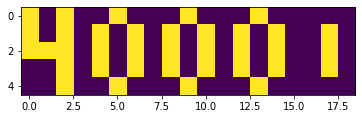

In [43]:
print(ds)
plt.imshow(obs)

In [44]:
def get_f(obs_unnorm):
    obs = unperm(obs_unnorm)
    ds = obs_to_digits(obs)
    ds = [decode_digit(d) for d in ds]
    return ds

In [45]:
features = np.array([get_f(obs) for obs in obs_x_unnorm])

[1 0 1 1 2]


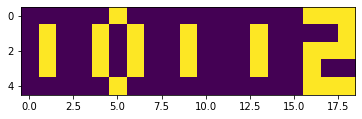

In [46]:
print(features[123])
plt.imshow(unperm(obs_x_unnorm[123]))

In [47]:
f_pred = l.decoder(ctx['obs_x']).detach().cpu().numpy()

In [49]:
df_pred = pd.DataFrame(f_pred, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
df_true = pd.DataFrame(features, columns=['d1', 'd2', 'd3', 'd4', 'd5'])

In [50]:
df_all = pd.concat([df_pred, df_true], axis=1)
df_all['step'] = df_all['d1'] + df_all['d2'] + df_all['d3'] + df_all['d4'] + df_all['d5']

<AxesSubplot:>

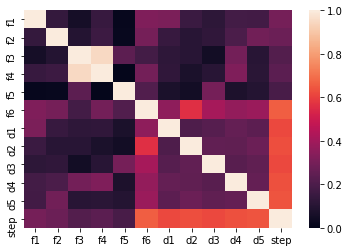

In [51]:
sns.heatmap(np.abs(df_all.corr()), vmin=0, vmax=1)

In [52]:
import statsmodels.api as sm
from patsy import dmatrices

In [54]:
y, X = dmatrices('step ~ f1 + f2 + f3 + f4 + f5', data=df_all, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   step   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     106.5
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           4.76e-90
Time:                        22:57:30   Log-Likelihood:                -2670.0
No. Observations:                1000   AIC:                             5352.
Df Residuals:                     994   BIC:                             5381.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1173      0.324     25.045      0.000       7.481       8.753
f1            -0.2629      0.019    -13.886      0.000      -0.300      -0.226
f2            -0.1439      0.012    -12.015      0.000      -0.167      -0.120
f3            -0.6432      0.044    -14.603      0.000      -0.730      -0.557
f4            -0.4217      0.032    -13.138      0.000      -0.485      -0.359
f5             0.3585      0.022     16.072      0.000       0.315       0.402
==============================================================================
Omnibus:                       29.533   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.446
Skew:                           0.272   Prob(JB):                     1.34e-05
Kurtosis:                       2.508   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

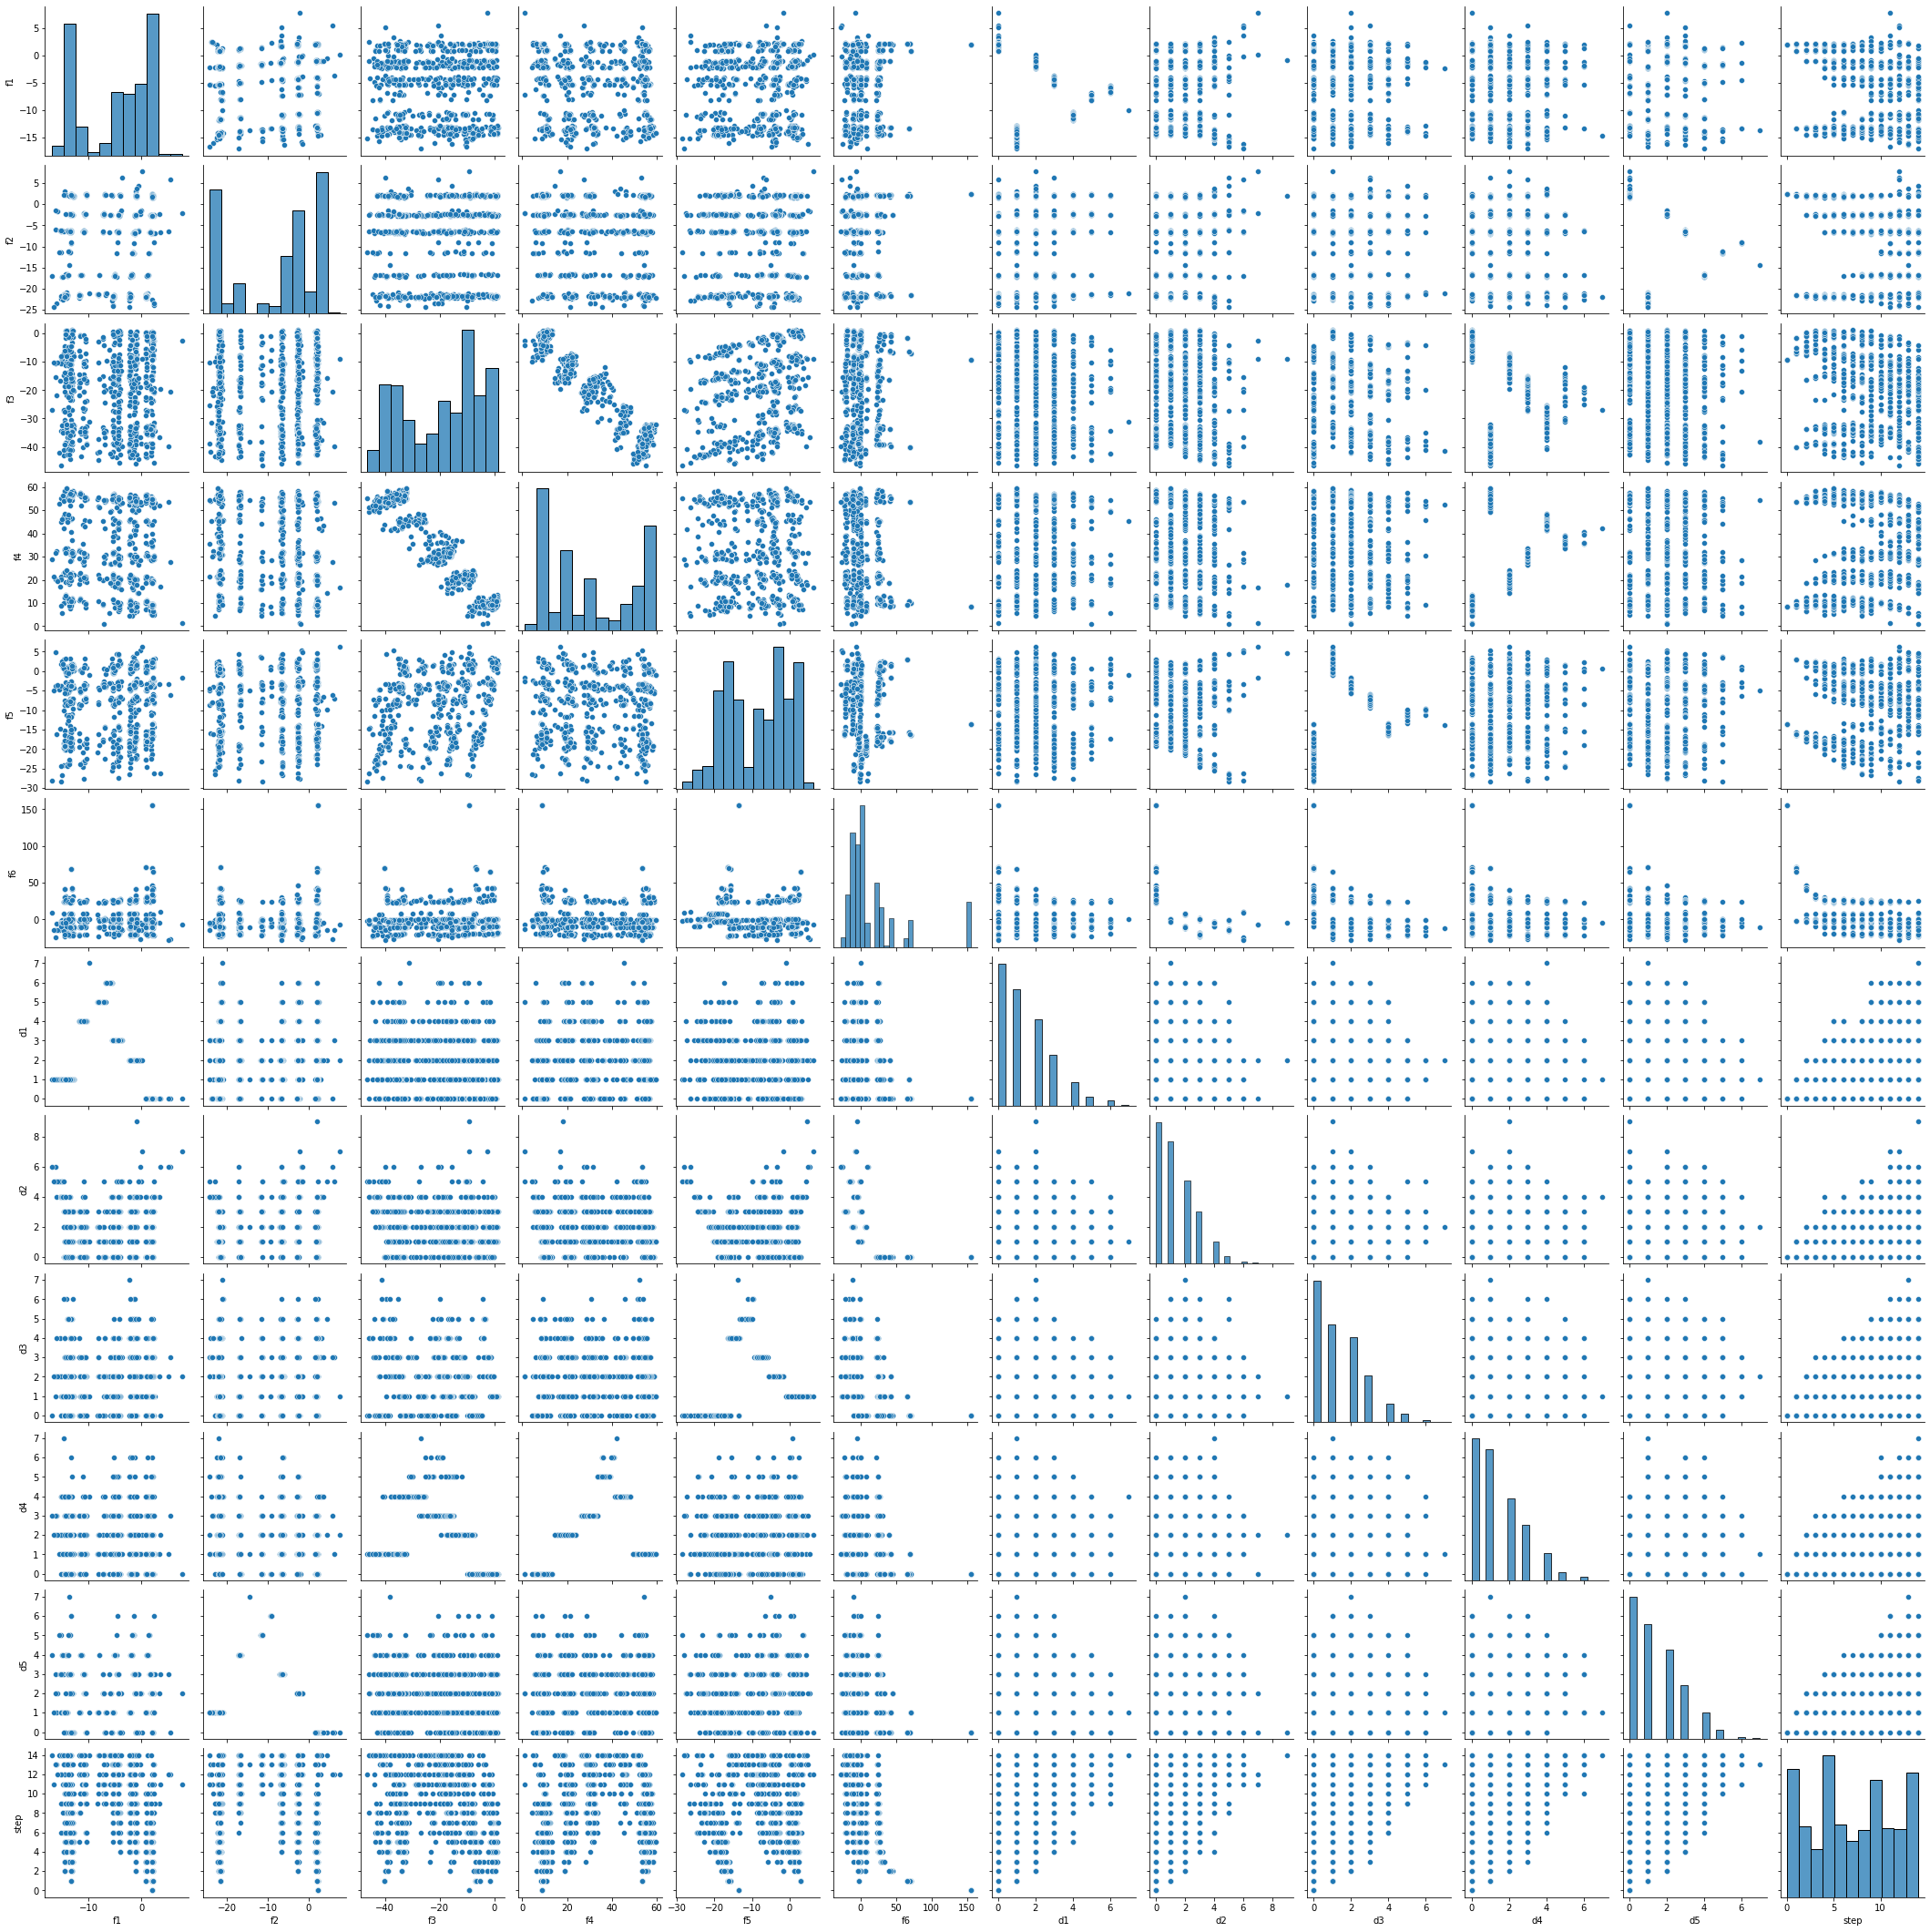

In [55]:
sns.pairplot(df_all)

In [57]:
import tensorflow as tf

In [58]:
m = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_shape=(6,), activation='tanh'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(5, activation=None)
])
m.compile('adam', 'mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [59]:
h = m.fit(np.array(df_pred), np.array(df_true), epochs=2000, verbose=0)

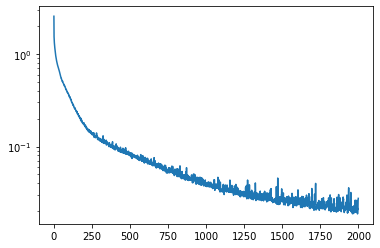

In [60]:
plt.plot(h.history['loss'])
plt.yscale('log')

In [61]:
# The model learns a pretty much random values for the features...
# trying post-features

In [62]:
f_pred_post = l.rot_pre(l.decoder(ctx['obs_x'])).detach().cpu().numpy()

In [63]:
df_pred = pd.DataFrame(f_pred_post, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
df_true = pd.DataFrame(features, columns=['d1', 'd2', 'd3', 'd4', 'd5'])

In [64]:
df_all = pd.concat([df_pred, df_true], axis=1)
df_all['step'] = df_all['d1'] + df_all['d2'] + df_all['d3'] + df_all['d4'] + df_all['d5']

<AxesSubplot:>

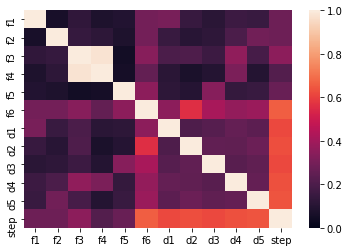

In [65]:
sns.heatmap(np.abs(df_all.corr()), vmin=0, vmax=1)

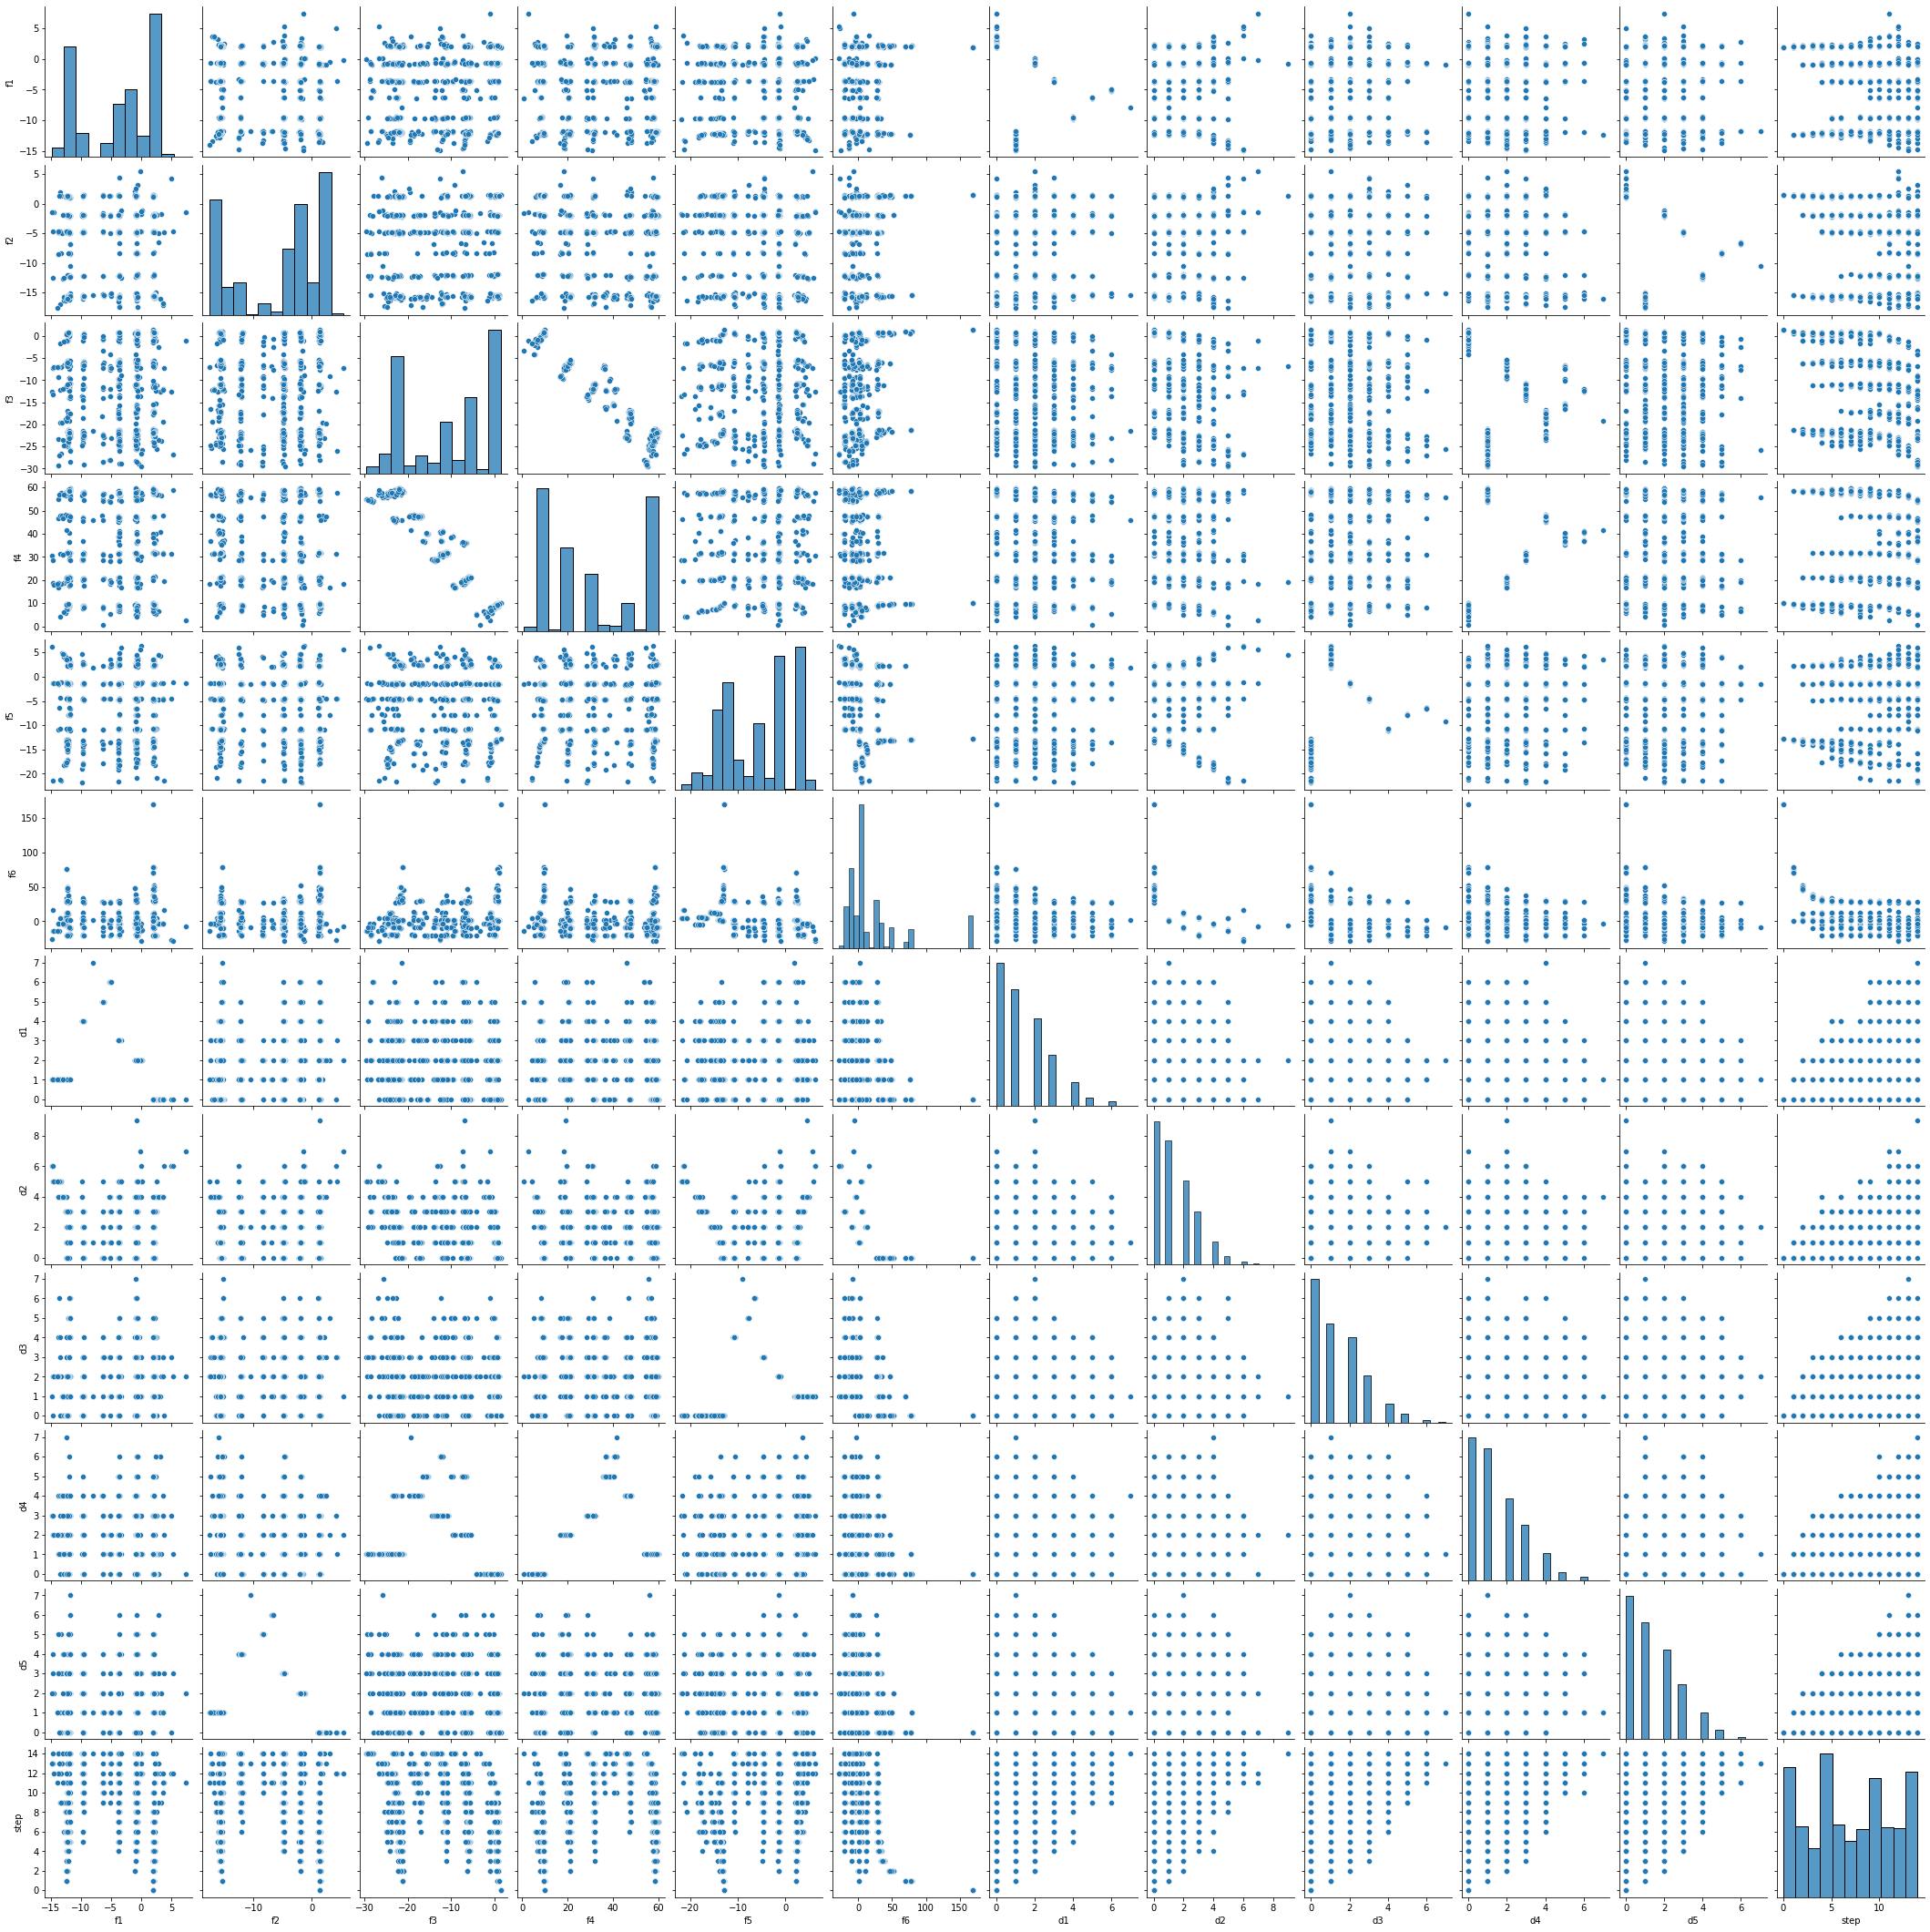

In [66]:
sns.pairplot(df_all)

# Creating an animated graph gif...

In [5]:
from plot_gif_model import gifify_trial_images, display_image, plot_hist_values, get_trial_by_epochs

In [6]:
results = f'/home/sergei/ray_results/{config_name}/{trial_name}/result.json'

In [7]:
trial_by_epochs = get_trial_by_epochs(results)

In [24]:
display_image(gifify_trial_images(trial_by_epochs, 'CausalModel.png'))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/CausalModel.png_all.gif

In [25]:
display_image(gifify_trial_images(trial_by_epochs, 'model.png'))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/model.png_all.gif

In [26]:
trial_by_epochs[0]

{'epochs': 0,
 'n_samples': 1000,
 'losses/opt1/fit/coeff': 0.14,
 'losses/opt1/fit/value': 262.5650939941406,
 'losses/opt1/sparsity/coeff': 0.02,
 'losses/opt1/sparsity/value': 58.29999923706055,
 'losses/opt1/fit_all_on/coeff': 0.05,
 'losses/opt1/fit_all_on/value': 382.5262756347656,
 'losses/opt1/reconstruction/coeff': 0.01,
 'losses/opt1/reconstruction/value': 77.40986633300781,
 'losses/opt1/fit_all_half/coeff': 0.01,
 'losses/opt1/fit_all_half/value': 253.43942260742188,
 'losses/opt1/value': 60.359920501708984,
 'grads/opt1/grad_total_l1mean': 3.060454137280407,
 'grads/opt1/grad_total_l2sum': 926.9329749668159,
 'metrics/batch_index': 0,
 'metrics/batch_size': -1,
 'metrics/fit/mean_feature': '[ 0.03433687  0.12825611 -0.04708277  0.10400862 -0.06344575  0.04275775]',
 'metrics/fit/std_feature': '[0.06169575 0.08960629 0.05721147 0.06226677 0.08051208 0.06895346]',
 'metrics/fit/min_feature': -0.23282650113105774,
 'metrics/fit/max_feature': 0.3464719355106354,
 'metrics/fit/

In [27]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'losses/opt1/sparsity/value')))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/lossesopt1sparsityvalue.png_all.gif

In [28]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/|last_mult_sparsity_gap', log=True)))

/home/sergei/causality-disentanglement-rl/causal_analysis/plot_gif_model.py:156: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricslastmultsparsitygap.png_all.gif

In [29]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/nnz', log=False)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsnnz.png_all.gif

In [30]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'losses/opt1/fit/value', log=True)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/lossesopt1fitvalue.png_all.gif

In [31]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/fit/rec_fit_acc_loss_01_agg', log=False)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsfitrecfitaccloss01agg.png_all.gif

In [32]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/fit/loss_fcons', log=True)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsfitlossfcons.png_all.gif

In [33]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/fit/loss_rec', log=True)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsfitlossrec.png_all.gif

# Showing which weights change

In [84]:
import gin
import sparse_causal_model_learner_rl.config
from causal_util.helpers import lstdct2dctlst
gin.enter_interactive_mode()

In [40]:
gin.bind_parameter('Config._unpickle_skip_init', True)

In [43]:
checkpoints_by_epochs = {epoch: trial.get('checkpoint_tune', None) for epoch, trial in trial_by_epochs.items()}
checkpoints_by_epochs = {x: y for x, y in checkpoints_by_epochs.items() if y is not None}

In [54]:
epochs = sorted(checkpoints_by_epochs.keys())
ckpts = [checkpoints_by_epochs[e] for e in epochs]

In [55]:
weights_by_epochs = [
    CPU_Unpickler(open(ckpt, 'rb')).load()._unpickled_state['trainables_weights']
    for ckpt in tqdm(ckpts)
]

In [89]:
def flat_weights_dict(w):
    """{model: {w: val}} -> {model/w -> val}."""
    w_flat = {}
    endswith_blacklist = ['num_batches_tracked', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var']
    for trainable, t_weights in w.items():
        for w_name, w_value in t_weights.items():
            if any([w_name.endswith(t) for t in endswith_blacklist]):
                continue
            w_flat[f'{trainable}/{w_name}'] = w_value
    return w_flat

In [90]:
ws_flat = [flat_weights_dict(w) for w in weights_by_epochs]
wkeys = sorted(ws_flat[0].keys())

In [96]:
prev = ws_flat[0]
ws_flat_delta = []

for item in tqdm(ws_flat):
    ws_flat_delta_item = {}
    for wkey in wkeys:
        prev_item = prev[wkey]
        curr_item = item[wkey]
        scale = prev_item.abs()
        scale = torch.where(scale < 1e-8, torch.ones_like(scale), scale)
        delta = ((prev_item - curr_item) / scale).abs().mean().item()
        ws_flat_delta_item[wkey] = delta
    ws_flat_delta.append(ws_flat_delta_item)
    prev = item

In [97]:
deltas_dct = lstdct2dctlst(ws_flat_delta)

In [100]:
deltas_dct.keys()

dict_keys(['decoder/model.fc01.bias', 'decoder/model.fc01.weight', 'decoder/model.fc02.bias', 'decoder/model.fc02.weight', 'decoder/model.fc03.bias', 'decoder/model.fc03.weight', 'decoder/model.fc04.bias', 'decoder/model.fc04.weight', 'decoder/model.fc05.bias', 'decoder/model.fc05.weight', 'model/model.model.fc01.bias', 'model/model.model.fc01.weight', 'model/model.model.fc02.bias', 'model/model.model.fc02.weight', 'model/model.model.fc03.bias', 'model/model.model.fc03.weight', 'model/model.model.fc04.bias', 'model/model.model.fc04.weight', 'model/model.switch.probas', 'reconstructor/model.fc01.bias', 'reconstructor/model.fc01.weight', 'reconstructor/model.fc02.bias', 'reconstructor/model.fc02.weight', 'reconstructor/model.fc03.bias', 'reconstructor/model.fc03.weight', 'reconstructor/model.fc04.bias', 'reconstructor/model.fc04.weight', 'reconstructor/model.fc05.bias', 'reconstructor/model.fc05.weight', 'rot_post/rot.bias', 'rot_post/rot.weight', 'rot_pre/rot.bias', 'rot_pre/rot.weight'

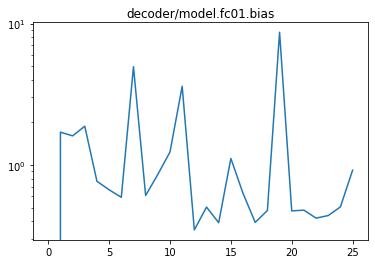

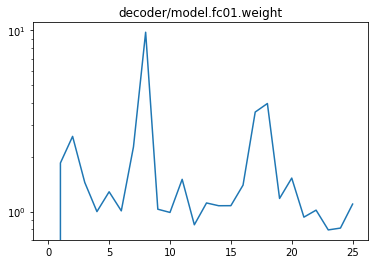

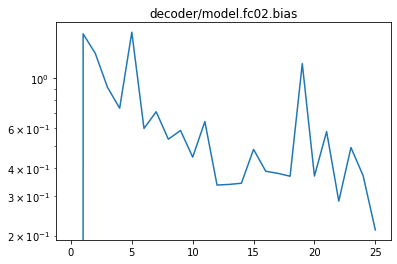

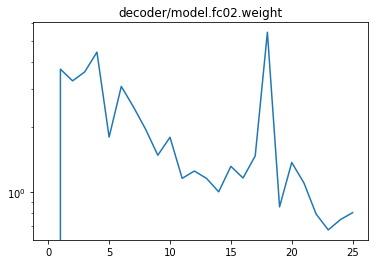

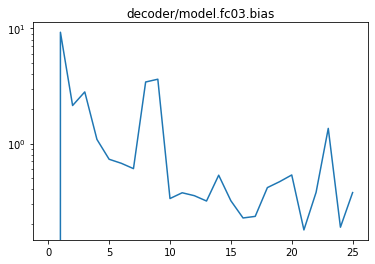

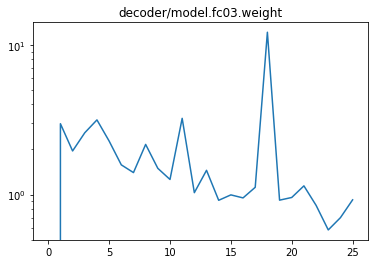

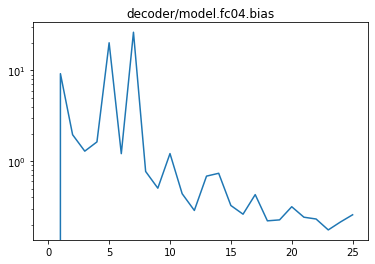

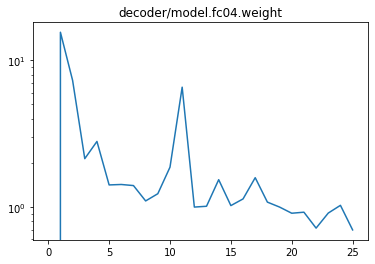

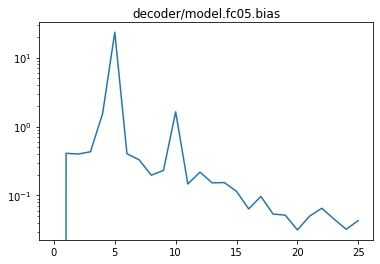

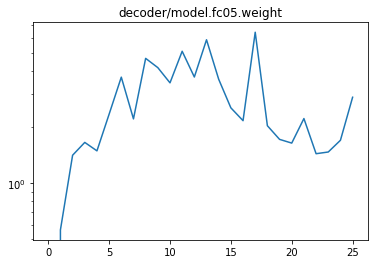

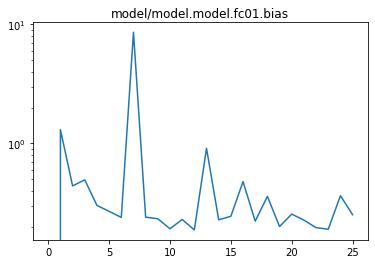

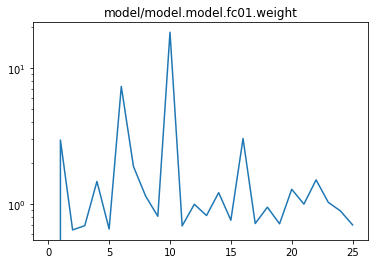

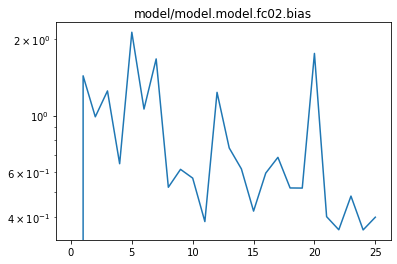

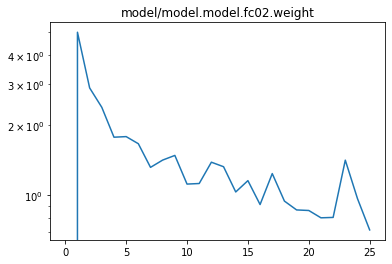

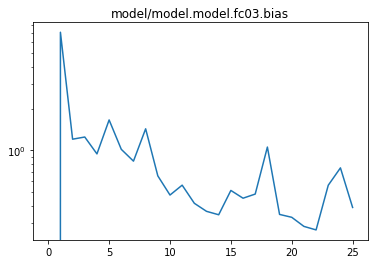

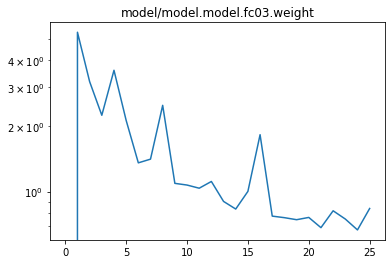

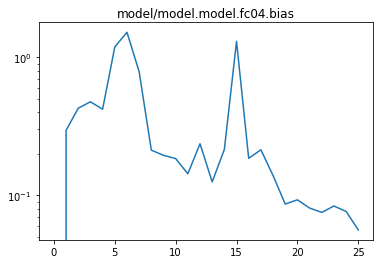

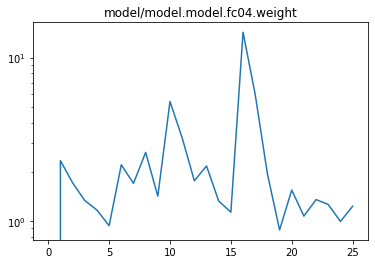

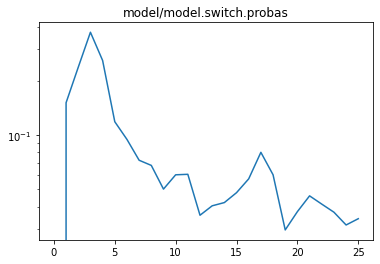

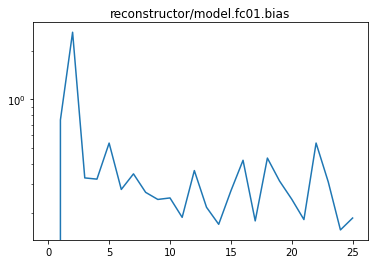

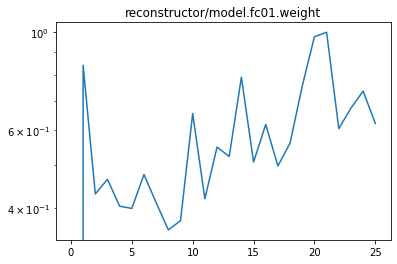

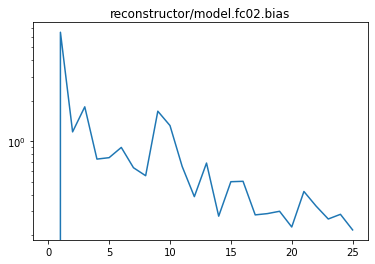

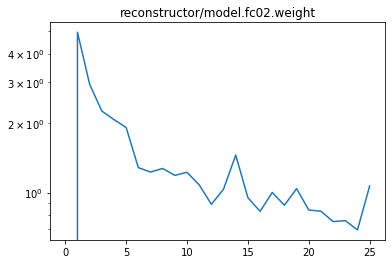

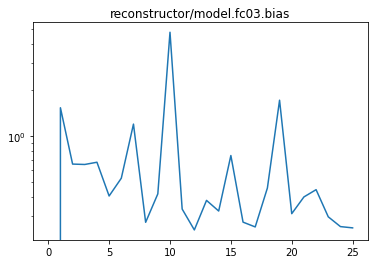

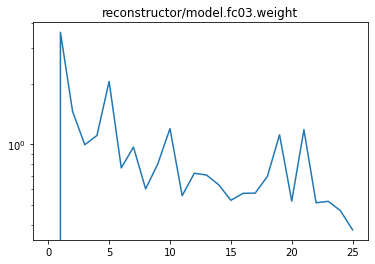

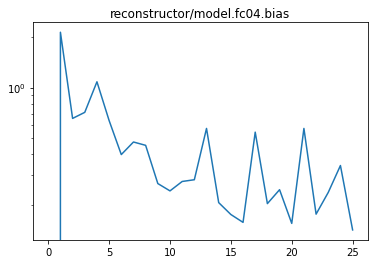

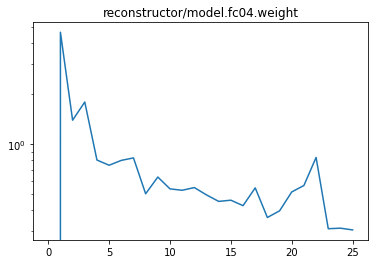

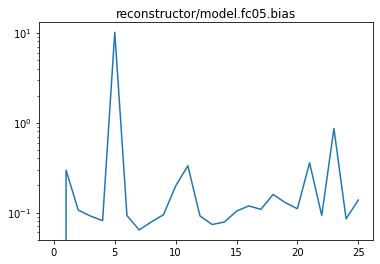

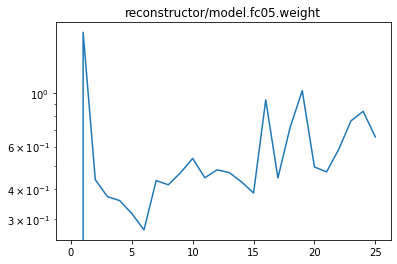

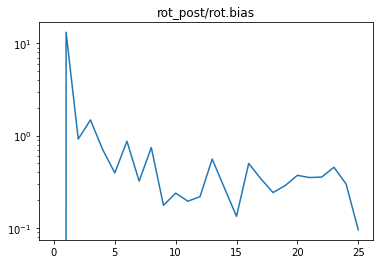

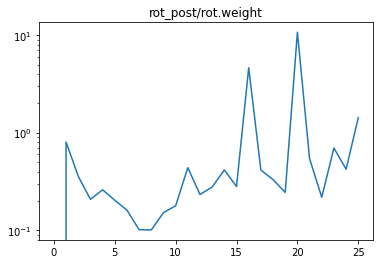

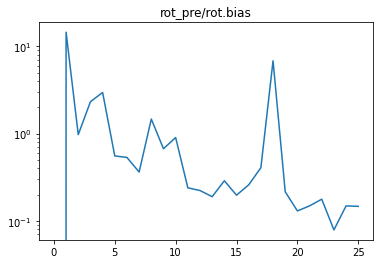

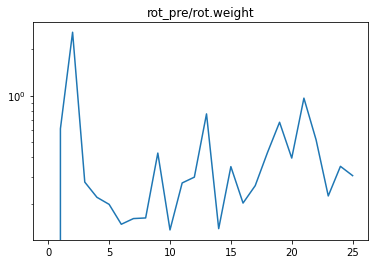

In [99]:
for key, vals in deltas_dct.items():
    plt.figure()
    plt.title(key)
    plt.plot(vals)
    plt.yscale('log')
    plt.show()

In [104]:
# grouping by trainable
deltas_dct_bytrainable = {}
for key, vals in deltas_dct.items():
    trainable, _ = key.split('/')
    if trainable not in deltas_dct_bytrainable:
        deltas_dct_bytrainable[trainable] = np.zeros(len(vals))
    deltas_dct_bytrainable[trainable] += vals

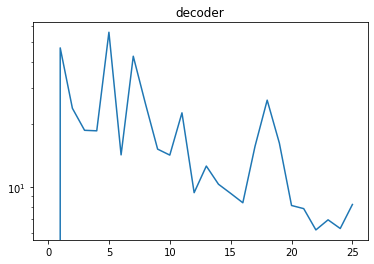

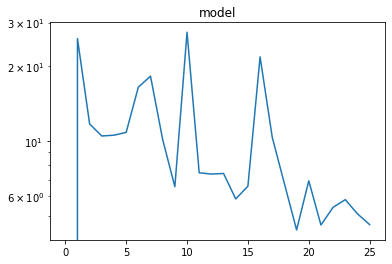

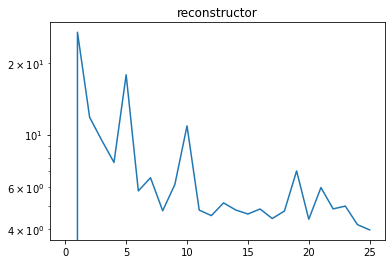

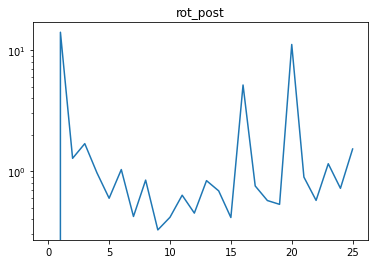

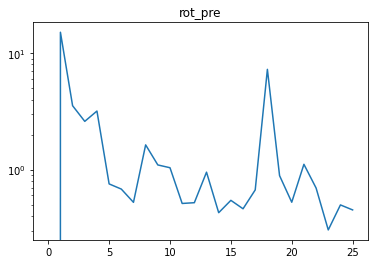

In [106]:
for key, vals in deltas_dct_bytrainable.items():
    plt.figure()
    plt.title(key)
    plt.plot(vals)
    plt.yscale('log')
    plt.show()